In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from colorthief import ColorThief
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization, Lambda, AveragePooling2D, ZeroPadding2D, Reshape, Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

#### GPU Checks for Tensorflow

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### EDA

#### Train Data

In [6]:
# Folder containing all the training data.
car_train = "Data/car_data/car_data/train/"
print('There are', len(os.listdir(car_train)),'folders in the training dataset')

There are 196 folders in the training dataset


In [7]:
mylist = []
for labels in os.listdir(car_train):
    for label in os.listdir(car_train+labels): 
        car_add = car_train + labels + '/' + label
        car_value = (labels, car_add)                
        if car_value not in mylist:
            mylist.append(car_value)
            
train_df = pd.DataFrame(np.array(mylist), columns= ["car", "image path"])

In [9]:
# Create train_df
train_df.sample(10)

,car,image path
7477,Spyker C8 Coupe 2009,Data/car_data/car_data/train/Spyker C8 Coupe 2...
614,Audi RS 4 Convertible 2008,Data/car_data/car_data/train/Audi RS 4 Convert...
8065,Volvo C30 Hatchback 2012,Data/car_data/car_data/train/Volvo C30 Hatchba...
4614,Ford Fiesta Sedan 2012,Data/car_data/car_data/train/Ford Fiesta Sedan...
5765,Hyundai Veloster Hatchback 2012,Data/car_data/car_data/train/Hyundai Veloster ...
2947,Chevrolet Sonic Sedan 2012,Data/car_data/car_data/train/Chevrolet Sonic S...
2137,Cadillac SRX SUV 2012,Data/car_data/car_data/train/Cadillac SRX SUV ...
6615,Mercedes-Benz 300-Class Convertible 1993,Data/car_data/car_data/train/Mercedes-Benz 300...
1296,BMW 1 Series Convertible 2012,Data/car_data/car_data/train/BMW 1 Series Conv...
6908,Mitsubishi Lancer Sedan 2012,Data/car_data/car_data/train/Mitsubishi Lancer...


#### Test Data

In [10]:
# Folder containng all the files for the test set. 
car_test= "Data/car_data/car_data/test/"
print('There are', len(os.listdir(car_test)),'folders in the test dataset')

There are 196 folders in the test dataset


In [11]:
# Create test_df
mylist2 = []
for labels in os.listdir(car_test):
    for label in os.listdir(car_test+labels): 
        car_add = car_test + labels + '/' + label
        car_value = (labels, car_add)                
        if car_value not in mylist:
            mylist2.append(car_value)   

test_df = pd.DataFrame(np.array(mylist2), columns= ["car", "image path"])

In [13]:
test_df.sample(10)

,car,image path
6155,Lamborghini Diablo Coupe 2001,Data/car_data/car_data/test/Lamborghini Diablo...
2241,Chevrolet Cobalt SS 2010,Data/car_data/car_data/test/Chevrolet Cobalt S...
6728,Mercedes-Benz Sprinter Van 2012,Data/car_data/car_data/test/Mercedes-Benz Spri...
5445,Hyundai Elantra Touring Hatchback 2012,Data/car_data/car_data/test/Hyundai Elantra To...
3265,Chrysler Town and Country Minivan 2012,Data/car_data/car_data/test/Chrysler Town and ...
1743,BMW Z4 Convertible 2012,Data/car_data/car_data/test/BMW Z4 Convertible...
525,Audi A5 Coupe 2012,Data/car_data/car_data/test/Audi A5 Coupe 2012...
3048,Chrysler 300 SRT-8 2010,Data/car_data/car_data/test/Chrysler 300 SRT-8...
3662,Dodge Durango SUV 2007,Data/car_data/car_data/test/Dodge Durango SUV ...
1369,BMW 3 Series Sedan 2012,Data/car_data/car_data/test/BMW 3 Series Sedan...


### Creating Color Classifications

#### Function to obtain most dominant color in image and return rgb

In [15]:
# Load in colors.csv and create df with index as color
clr_headers = ['color', 'full_name', 'hex', 'r', 'g', 'b'] # list for header
colors = pd.read_csv('colors.csv', names=clr_headers, index_col = 'color') # Load in csv
colors['rgb'] = list(zip(colors['r'], colors['g'], colors['b'])) # combine r/g/b as rgb tuple
colors_df = colors.drop(columns=['full_name', 'hex', 'r', 'g', 'b']) # drop old columns and save to new df
colors_dict = dict(zip(colors_df.index, colors_df['rgb'])) # create dictionary with color(key):rgb(value)

def classify_color(filepath):
    # Color thief will find the most dominant rgb color in an image
    color_thief = ColorThief(filepath)
    dominant_color = color_thief.get_color(quality=1)

    # Manhattan distance between "classification points"
    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) 
    
    # Find the best color in dictionary and find Manhattan distance
    distances = {k: manhattan(v, dominant_color) for k, v in colors_dict.items()}
    
    # Minimum distance to color point
    color = min(distances, key=distances.get) 
    return color

#### Train Categorization

In [16]:
# Will not re-run. Takes 2.5 hours.
# train_df['color'] = train_df['image path'].apply(classify_color)

In [29]:
# # Save to csv
# train_df.to_csv('train_df_color')

In [49]:
# Load in categorized data
train_df = pd.read_csv('train_df_color.csv')
train_df = train_df[['car', 'image path', 'color', 'car label']]

In [50]:
# Create column for car label based on color
train_df['car_label'] = train_df.color.astype("category").cat.codes
train_df['car_label'] = train_df['car_label'].astype("str")

In [51]:
# Most frequent colors
train_df.groupby(train_df['car_label']).count().sort_values(by='color', ascending=False).head(10)

,car,image path,color,car label,car_label
car_label,,,,,
104,608,608,608,608,608
75,433,433,433,433,433
20,426,426,426,426,426
19,347,347,347,347,347
58,343,343,343,343,343
8,339,339,339,339,339
133,330,330,330,330,330
134,314,314,314,314,314
183,284,284,284,284,284


In [52]:
train_img_df = train_df[['image path', 'car_label']].copy()
train_img_df.sample(5)

,image path,car_label
3787,Data/car_data/car_data/train/Dodge Durango SUV...,75
5514,Data/car_data/car_data/train/Hyundai Elantra T...,188
7156,Data/car_data/car_data/train/Porsche Panamera ...,183
4777,Data/car_data/car_data/train/Ford Mustang Conv...,154
4125,Data/car_data/car_data/train/Ferrari 458 Itali...,14


In [53]:
train_img_df.shape

(8144, 2)

#### Test Categorization

Repeat of steps above for test dataset.

In [54]:
# # Will not re-run. Takes 2.5 hours.
# test_df['color'] = test_df['image path'].apply(classify_color)

In [55]:
# # Save to csv
# test_df.to_csv('Data/test_df_color')

In [56]:
test_df = pd.read_csv("test_df_color.csv")

In [57]:
test_df['car_label'] = test_df.color.astype("category").cat.codes
test_df['car_label'] = test_df['car_label'].astype("str")

In [58]:
test_df.head()

,Unnamed: 0,car,image path,color,car_label
0,0,Acura Integra Type R 2001,Data/car_data/car_data/test/Acura Integra Type...,grullo,106
1,1,Acura Integra Type R 2001,Data/car_data/car_data/test/Acura Integra Type...,jet,111
2,2,Acura Integra Type R 2001,Data/car_data/car_data/test/Acura Integra Type...,light_gray,121
3,3,Acura Integra Type R 2001,Data/car_data/car_data/test/Acura Integra Type...,lavender_gray,117
4,4,Acura Integra Type R 2001,Data/car_data/car_data/test/Acura Integra Type...,arsenic,6


In [59]:
test_df.groupby(test_df['car_label']).count().sort_values(by='color', ascending=False).head(10)

,Unnamed: 0,car,image path,color,car_label
car_label,,,,,
111,591,591,591,591,591
82,465,465,465,465,465
21,438,438,438,438,438
20,376,376,376,376,376
66,349,349,349,349,349
6,332,332,332,332,332
143,312,312,312,312,312
145,299,299,299,299,299
193,295,295,295,295,295


In [60]:
test_img_df = test_df[['image path', 'car_label']].copy()
test_img_df.sample(5)

,image path,car_label
6022,Data/car_data/car_data/test/Jeep Patriot SUV 2...,67
6460,Data/car_data/car_data/test/McLaren MP4-12C Co...,111
6133,Data/car_data/car_data/test/Lamborghini Aventa...,21
7622,Data/car_data/car_data/test/Toyota 4Runner SUV...,143
5727,Data/car_data/car_data/test/Hyundai Veracruz S...,145


In [61]:
test_img_df.shape

(8041, 2)

#### Generators

This will allow us to scale and reshape the data. Also split the training datset into training and validation datasets. 

Test dataset is kept isolated. 

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [62]:
# ImageDataGenerator for training and validation
datagen = ImageDataGenerator(rescale=1./255,       
                             shear_range=0.2,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             brightness_range=[0.5,1.5],
                             validation_split=0.25)

In [63]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train_img_df,
    directory = None,
    x_col="image path",
    y_col="car_label",
    has_ext=True,                                     
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224), 
    color_mode='rgb'
)

Found 6108 validated image filenames belonging to 200 classes.


In [64]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_img_df,
    directory = None, 
    x_col="image path",
    y_col="car_label",
    has_ext=True,
    subset="validation",
    batch_size=2,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224), 
    color_mode='rgb'
)

Found 2036 validated image filenames belonging to 200 classes.


In [65]:
# ImageDataGenerator for testing
test_datagen=ImageDataGenerator(rescale=1./255)

In [66]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_img_df,

    directory = None,
    x_col="image path",
    y_col=None, # None for testing
#     has_ext=True,
    batch_size=32,
    seed=42,
    shuffle=False, # yield images in order
    class_mode=None, # return only the images
    target_size=(224,224),
    color_mode ='rgb'
)

Found 8041 validated image filenames.


In [68]:
# Defining epoch step sizes based on number of images divided by batch size
step_train = train_generator.n//train_generator.batch_size
step_valid = valid_generator.n//valid_generator.batch_size
step_test = test_generator.n//test_generator.batch_size

#### CNN Model

https://github.com/beerboaa/Color-Classification-CNN
https://arxiv.org/pdf/1510.07391.pdf

In [69]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Conv2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [120]:
num_classes = 200
nb_epoch = 15

# initialise model
model = color_net(num_classes)

filepath = 'color_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit(
                    train_generator,
                    steps_per_epoch=step_train,
                    epochs=nb_epoch,
                    validation_data=valid_generator,
                    validation_steps=step_valid,
                    callbacks=callbacks_list,
                    verbose=1)

model.save('color_model')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 190 steps, validate for 1018 steps
Epoch 1/15
189/190 [============================>.] - ETA: 0s - loss: 4.3673 - accuracy: 0.0548
Epoch 00001: val_accuracy improved from -inf to 0.05059, saving model to color_weights.hdf5
190/190 [==============================] - 135s 712ms/step - loss: 4.3675 - accuracy: 0.0548 - val_loss: 4.5338 - val_accuracy: 0.0506
Epoch 2/15
189/190 [============================>.] - ETA: 0s - loss: 4.0765 - accuracy: 0.0685
Epoch 00002: val_accuracy improved from 0.05059 to 0.10707, saving model to color_weights.hdf5
190/190 [==============================] - 131s 690ms/step - loss: 4.0751 - accuracy: 0.0690 - val_loss: 4.0219 - val_accuracy: 0.1071
Epoch 3/15
189/190 [============================>.] - ETA: 0s - loss: 3.9509 - accuracy: 0.0869
Epoch 00003: val_accuracy improved from 0.10707 to 0.11837, saving model to color_weights.hdf5
190/190 [==============================] - 133s 701ms/step - loss

#### Evaluation

In [121]:
# Evaluate model
model.evaluate(
    valid_generator, 
    steps=STEP_SIZE_TEST, 
    verbose=1)

  ...
    to  
  ['...']
251/251 [==============================] - 7s 30ms/step - loss: 3.3654 - accuracy: 0.1594


[3.365352573147808, 0.15936255]

In [122]:
# Model Summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 54, 54, 48)   17472       input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 54, 54, 48)   17472       input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 54, 54, 48)   192         conv2d_96[0][0]                  
____________________________________________________________________________________________

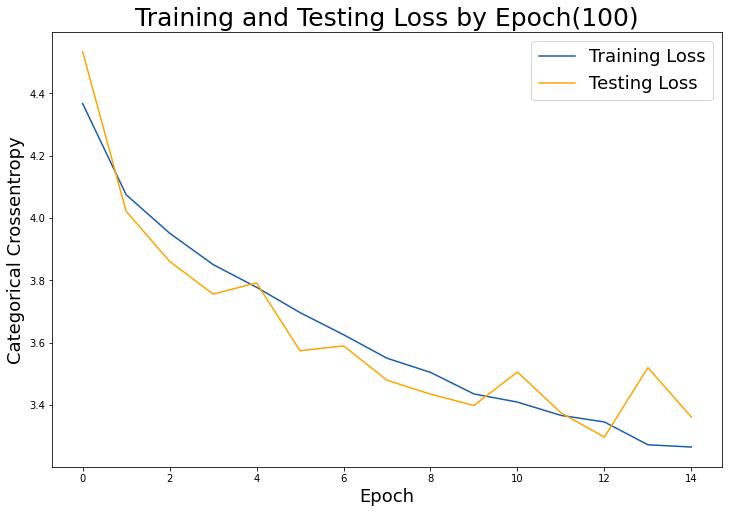

In [123]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch(100)', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks(len(100), lables=10)

plt.legend(fontsize = 18);

#### Predictions

In [124]:
# Predict
test_generator.reset()
pred=model.predict(test_generator,verbose=1)

252/252 [==============================] - 55s 217ms/step


In [125]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

[173   7   7 ...  21  21 178]


In [126]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [127]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results",index=False)

In [128]:
results = pd.read_csv('results')

results

,Filename,Predictions
0,Data/car_data/car_data/test/Acura Integra Type...,75
1,Data/car_data/car_data/test/Acura Integra Type...,104
2,Data/car_data/car_data/test/Acura Integra Type...,104
3,Data/car_data/car_data/test/Acura Integra Type...,48
4,Data/car_data/car_data/test/Acura Integra Type...,104
...,...,...
8036,Data/car_data/car_data/test/Volvo XC90 SUV 200...,113
8037,Data/car_data/car_data/test/Volvo XC90 SUV 200...,133
8038,Data/car_data/car_data/test/Volvo XC90 SUV 200...,117
8039,Data/car_data/car_data/test/Volvo XC90 SUV 200...,117


In [129]:
results2 = results.copy()
results2 = results2.join(test_df)

In [130]:
mylist = ['Unnamed: 0', 'Filename', 'image path']

In [131]:
results2.drop(columns = results2[mylist], inplace=True)

In [132]:
mycolumns = ['car', 'color', 'car_label', 'Predictions']

In [133]:
results2.sample(10)

,Predictions,car,color,car_label
2395,113,Chevrolet Express Cargo Van 2007,dark_jungle_green,66
3339,144,Dodge Caliber Wagon 2007,khaki_html_css_khaki,112
1492,75,BMW M3 Coupe 2012,dim_gray,82
459,8,Audi 100 Sedan 1994,outer_space,145
4546,104,Ford Fiesta Sedan 2012,black_leather_jacket,20
2241,144,Chevrolet Cobalt SS 2010,redwood,171
4132,18,Ferrari FF Coupe 2012,terra_cotta,196
5667,111,Hyundai Veloster Hatchback 2012,earth_yellow,84
1508,8,BMW M3 Coupe 2012,black_olive,21
5559,104,Hyundai Sonata Hybrid Sedan 2012,deep_coffee,78


In [134]:
results2.loc[results2['Predictions'] == results2.car_label, :]

,Predictions,car,color,car_label
